# SMP and snow pit profile matching
An example of SMP profiles at snow pit locations are scaled to account for differences
in the target snowpack structure. Because the SMP and density cutter profiles are physically
displaced we use a brute-force approach to match them as best as possible using a 4 step
procedure

1. Make a first guess at the density from the SMP using the P15
2. Break up the SMP profile into L_RESAMPLE sized layers
3. Randomly scale each layer according to MAX_STRETCH_LAYER
4. Compare against density profile
5. Select best fit scaling where RMSE and R are optimized


In [10]:
# Community packages
import os 
import numpy as np
np.random.seed(2019) 
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
from scipy import stats
from statsmodels.formula.api import ols
import pickle


# Local packages
import smpfunc #SMP helper functions

# Import SLF SMP Package
from snowmicropyn import Profile, proksch2015, loewe2012

# Import data
pit_summary = pd.read_csv("./data/Pit/pit_summary.csv")
pit_desnity = pd.read_csv("./data/Pit/pit_density.csv")
input_data = os.path.abspath("./data/SMP/Calibration")
pit_desnity['BOTTOM'] = pit_desnity['BOTTOM'] - pit_desnity['Height correction mm']
pit_desnity['TOP'] = pit_desnity['TOP'] - pit_desnity['Height correction mm']


# Set constants
CUTTER_SIZE = 2.5 #15 # Half the height of the density cutter in mm
WINDOW_SIZE = 5 # SMP analysis window in mm
H_RESAMPLE = 1 # delta height in mm for standardized SMP profiles
L_RESAMPLE = 25 # layer unit height in mm for SMP matching                   ## originally 50
MAX_STRETCH_LAYER = 0.75 # Max layer change in % of height
MAX_STRETCH_OVERALL = 0.15 # Max profile change in % of total height
NUM_TESTS = 10000

axis_value_size = 12
axis_label_size = 14

coeffs = pickle.load(open('./output/density_k20b_coeffs.pkl', 'rb'))

In [11]:
# Load the SMP calibration profiles, should be 25 for the ECCC case
def load_smp(smp_file):
    p = Profile.load(smp_file)
    p = smpfunc.preprocess(p, smoothing = 0)
    ground  = p.detect_ground()
    surface  = p.detect_surface()
    return p

file_list = [
    os.path.join(input_data, f)
    for f in sorted(os.listdir(input_data))
    if f.endswith(".pnt")]
        
smp_data = [load_smp(file) for file in file_list]
print(smp_data)

C:\Users\amyrm\Documents\GitHub\SMP-Sea-Ice\smpfunc.py:104: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  profile.samples.force[nans]= np.interp(x(nans), x(~nans), profile.samples.force[~nans])
C:\Users\amyrm\Documents\GitHub\SMP-Sea-Ice\smp

[<snowmicropyn.profile.Profile object at 0x000001F37D3874D0>, <snowmicropyn.profile.Profile object at 0x000001F3219C5D90>, <snowmicropyn.profile.Profile object at 0x000001F31CA45FD0>, <snowmicropyn.profile.Profile object at 0x000001F321DCA2D0>, <snowmicropyn.profile.Profile object at 0x000001F3217C0590>, <snowmicropyn.profile.Profile object at 0x000001F321E9FDD0>, <snowmicropyn.profile.Profile object at 0x000001F310A46750>, <snowmicropyn.profile.Profile object at 0x000001F31CB1F710>, <snowmicropyn.profile.Profile object at 0x000001F31CC35B10>, <snowmicropyn.profile.Profile object at 0x000001F321E9FC90>, <snowmicropyn.profile.Profile object at 0x000001F322EE9850>, <snowmicropyn.profile.Profile object at 0x000001F31CA92B50>, <snowmicropyn.profile.Profile object at 0x000001F321F08750>, <snowmicropyn.profile.Profile object at 0x000001F31C8CC1D0>, <snowmicropyn.profile.Profile object at 0x000001F31C8CF5D0>, <snowmicropyn.profile.Profile object at 0x000001F322EFFED0>, <snowmicropyn.profile.P

C:\Users\amyrm\Documents\GitHub\SMP-Sea-Ice\smpfunc.py:104: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  profile.samples.force[nans]= np.interp(x(nans), x(~nans), profile.samples.force[~nans])
C:\Users\amyrm\Documents\GitHub\SMP-Sea-Ice\smp

In [12]:
smp = smp_data[10]

smp_file_num = str(smp.name)
pit_df  = pit_summary[pit_summary['SMPF'] == smp_file_num] # Select the matching pit
density_df = pit_desnity[pit_desnity['ID'] == pit_df['ID'].values[0]]

density_df = density_df.assign(relative_height=np.abs(((density_df['TOP']) - CUTTER_SIZE) - density_df['TOP'].max()).values) ## removed *10 here!
# Make first guess at microstructure based on original profile
# l2012 = loewe2012.calc(smp.samples_within_snowpack(), window=WINDOW_SIZE)
# p2015 = proksch2015.calc(smp.samples_within_snowpack(), window=WINDOW_SIZE)
p2015 = loewe2012.calc(smp.samples_within_snowpack(), window=WINDOW_SIZE, overlap=50)
p2015['P2015_density']  = 312.54 + (50.27  * np.log(p2015.force_median)) + (-50.26 * np.log(p2015.force_median)  * p2015.L2012_L ) + (-85.35 * p2015.L2012_L)


# Estimate offset of the snow depth and SMP profile
smp_profile_height = p2015.distance.max()
smp_height_diff = 0 #pit_df.MPD.values*1000 - smp_profile_height

# Create new SMP resampled arrays and determine the number of layers
depth_array = np.arange(0, p2015.distance.max() + smp_height_diff, H_RESAMPLE)
density_array = np.interp(depth_array,p2015.distance,p2015.P2015_density)
force_array = np.interp(depth_array,p2015.distance,p2015.force_median)
l_array = np.interp(depth_array,p2015.distance,p2015.L2012_L)

smp_df = pd.DataFrame({'distance': depth_array, 
                       'density': density_array,
                       'force_median': force_array,
                       'l': l_array})

num_sections = np.ceil(len(smp_df.index)/L_RESAMPLE).astype(int)
random_tests = [smpfunc.random_stretch(x, MAX_STRETCH_OVERALL, MAX_STRETCH_LAYER) for x in np.repeat(num_sections, NUM_TESTS)] 

scaled_profiles = [smpfunc.scale_profile(test, smp_df.distance.values, smp_df.density.values, L_RESAMPLE, H_RESAMPLE) for test in random_tests]
compare_profiles = [smpfunc.extract_samples(dist, rho, density_df.relative_height.values, CUTTER_SIZE) for dist, rho in scaled_profiles]
compare_profiles = [pd.concat([profile, density_df.reset_index()], axis=1, sort=False) for profile in compare_profiles]
retrieved_skill = [smpfunc.calc_skill(profile, CUTTER_SIZE) for profile in compare_profiles]
retrieved_skill = pd.DataFrame(retrieved_skill,columns = ['r','rmse','rmse_corr','mae'])

C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_k

In [13]:
min_scaling_idx = retrieved_skill.sort_values(['r', 'rmse_corr'], ascending=[False, True]).head(1).index.values
min_scaling_coeff = random_tests[int(min_scaling_idx)]

dist, scaled_l =  smpfunc.scale_profile(min_scaling_coeff, smp_df.distance.values, smp_df.l.values, L_RESAMPLE, H_RESAMPLE)
dist, scaled_force_median = smpfunc.scale_profile(min_scaling_coeff, smp_df.distance.values, smp_df.force_median.values, L_RESAMPLE, H_RESAMPLE)

result = compare_profiles[int(min_scaling_idx)].assign(l=smpfunc.extract_samples(dist, scaled_l, density_df.relative_height.values, CUTTER_SIZE).mean_samp,
                                          force_median=smpfunc.extract_samples(dist, scaled_force_median, density_df.relative_height.values, CUTTER_SIZE).mean_samp)


C:\Users\amyrm\AppData\Local\Temp\ipykernel_24660\2351619403.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min_scaling_coeff = random_tests[int(min_scaling_idx)]
C:\Users\amyrm\AppData\Local\Temp\ipykernel_24660\2351619403.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = compare_profiles[int(min_scaling_idx)].assign(l=smpfunc.extract_samples(dist, scaled_l, density_df.relative_height.values, CUTTER_SIZE).mean_samp,


In [14]:
layer_thickness_scaled = L_RESAMPLE + (min_scaling_coeff * L_RESAMPLE)
layer_height_scalled = layer_thickness_scaled.cumsum()

layer_thickness = np.repeat(L_RESAMPLE, num_sections)
layer_height = layer_thickness.cumsum()

In [15]:
# Change in thickness
print((depth_array.max() - layer_thickness_scaled.sum())/depth_array.max())

-0.13788423274219544


In [16]:
density_k2020 = coeffs[0] + coeffs[1] * np.log(scaled_force_median) \
          + coeffs[2] * np.log(scaled_force_median) * scaled_l \
          + coeffs[3] * scaled_l

#### Figure 3 with caption

<img src="./output/figures/Fig03_matching_lowres.png" alt="Figure 3" style="width: 500px;"/>

#### Example of the SMP processing workflow to align first guess estimates of ρ_smp (Black lines) and snow pit measurements  (Red lines). Profiles are divided in arbitrary layers of 5 cm and randomly scaled in thickness. A best fit candidate is selected where RMSE between the snow density estimates and observations are minimized. The matching process is used to account for differences in the target snowpack between the two methods. The example shown is for Eureka site 5 on MYI.

C:\Users\amyrm\AppData\Local\Temp\ipykernel_24660\253162842.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax2.plot(scaled_profiles[int(min_scaling_idx)][1],
C:\Users\amyrm\AppData\Local\Temp\ipykernel_24660\253162842.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scaled_profiles[int(min_scaling_idx)][0], color = 'k')
C:\Users\amyrm\AppData\Local\Temp\ipykernel_24660\253162842.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax3.plot(density_k2020 ,

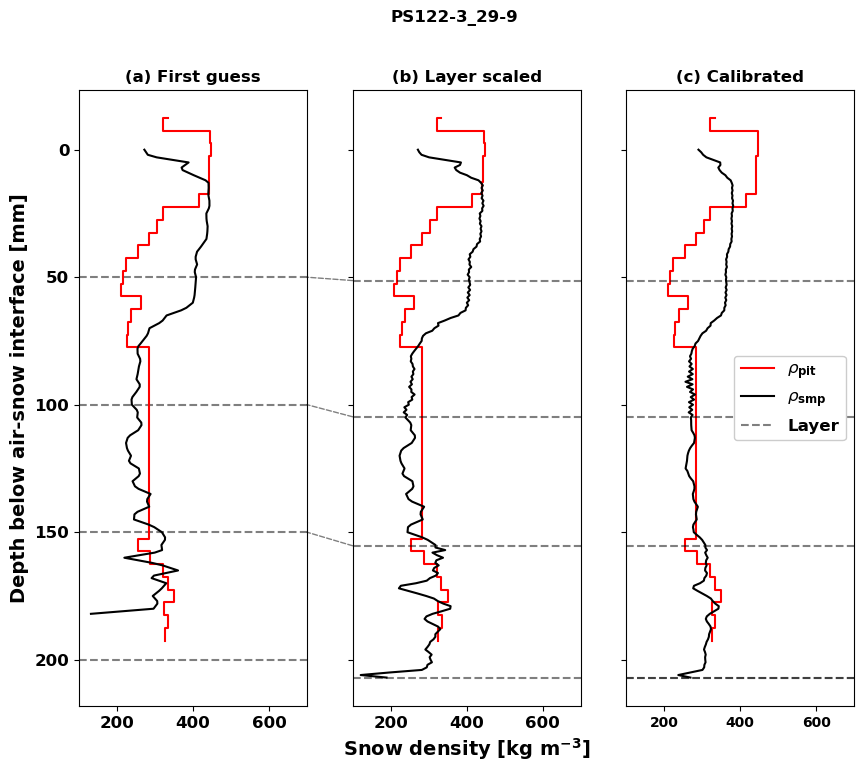

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,8))

ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)

xmax = 700
xmin = 100

for l in layer_height:
    ax1.axhline(y=l, color = 'k', alpha = 0.5, ls = 'dashed')

ax1.step(result.RHO, result.relative_height-15, color = 'r')   ## WHY result.relative_height-15 here??
ax2.step(result.RHO, result.relative_height-15, color = 'r')
ax3.step(result.RHO, result.relative_height-15, color = 'r', 
         label =  r'$\rho_{\mathrm{pit}}$')

ax1.plot(density_array, depth_array, color = 'k')

for l in layer_height_scalled:
    ax2.axhline(y=l, color = 'k', alpha = 0.5, ls = 'dashed')
    ax3.axhline(y=l, color = 'k', alpha = 0.5, ls = 'dashed')


    
ax2.plot(scaled_profiles[int(min_scaling_idx)][1],
         scaled_profiles[int(min_scaling_idx)][0], color = 'k')


for i in np.arange(0, len(layer_height)-1):
    xy = (xmin, layer_height_scalled[i])
    xy1 = (xmax,layer_height[i])
    con = ConnectionPatch(xyA=xy, xyB=xy1, coordsA="data", coordsB="data",
                       axesA=ax2, axesB=ax1, color="k", alpha = 0.5, ls = 'dashed')
    ax2.add_artist(con)
    
ax3.plot(density_k2020 ,scaled_profiles[int(min_scaling_idx)][0], 
         color = 'k', label = r'$\rho_{\mathrm{smp}}$')

# ax1.set_ylim(0,600)

ax1.set_xlim(xmin,xmax)
ax2.set_xlim(xmin,xmax)
ax3.set_xlim(xmin,xmax)

ax3.axhline(y=l, color = 'k', alpha = 0.5, ls = 'dashed', label = 'Layer')

ax1.set_ylabel('Depth below air-snow interface [mm]', fontsize=axis_label_size)
ax2.set_xlabel('Snow density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax1.set_title('(a) First guess')
ax2.set_title('(b) Layer scaled')
ax3.set_title('(c) Calibrated')

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

ax3.legend(fontsize=12, facecolor='white', framealpha=1)
event=result.ID.iloc[0].replace("/", "-")
plt.suptitle(event)

f.savefig('./output/figures/event_Fig03_matching_lowres/'+event+'.png', format='png')
f.savefig('./output/figures/event_Fig03_matching_lowres/'+event+'.pdf', format='pdf', dpi = 300)

In [ ]:
# Correlation after alignment
np.corrcoef(result.RHO, result.mean_samp)[1][0]

In [ ]:
# RMSE after alignment
np.sqrt(np.mean(result.RHO-result.mean_samp)**2)